In [11]:
import os
import sys
import pandas
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer
sys.path.insert(0,'/Users/ja8870vo/git/Vogel_PLS_Tx-Space/code/')
import CrossDecomp as XD

Here we will apply the PLS models developed in humans to mouse data, to understand the degree to which the spatiomolecular signals generalize to non-primate mammalian species. 

The data is taken from the Allen Mouse Brain Atlas. However, the data used here were primarily derivatives Lau et al., 2021 *Neuroimage* -- 10.1016/j.neuroimage.2020.117395

Data can be found in a zenodo repo associated with the paper: https://zenodo.org/records/4620136.

To run this notebook, you will need to go into that zenodo repo and download the file "voxelGeneExpression_P14.mat"

# Initialize data

First we need to load the data, and harmonize the gene expression information with the metadata

In [2]:
# Here you will need to change this path to wherever you downloaded the file to
filepath = '/Users/ja8870vo/Science/PLS_GXP/Mouse/voxelGeneExpression_P14.mat'


In [3]:
# load matfile
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    if '#' in k: continue
    arrays[k] = np.array(v)

In [4]:
coords = pandas.DataFrame(arrays['coOrds'])
print(coords.shape)
#print(arrays['geneIDs'].shape)
exp = pandas.DataFrame(arrays['voxGeneMat'])
print(exp.shape)
gdf = pandas.read_csv('./Mouse/AMBAGeneInfo.csv')
print(gdf.shape)
vdf = pandas.read_csv('./Mouse/AMBAvoxLabelTable.csv')
print(vdf.shape)

(3, 24213)
(2069, 24213)
(2015, 7)
(24213, 11)


In [5]:
# Match exp to gdf
eids = arrays['geneIDs'].astype(int)[0]
missing = list(set(eids) - set(gdf.entrezID.values))
print(len(missing),'missing from gdf')
gdf.loc[:,'orig_index'] = gdf.index.values
gdf.index = gdf.entrezID.values
gdf = gdf.reindex(eids)
gdf.entrezID = gdf.index
gdf.index = range(len(gdf))

54 missing from gdf


In [6]:
# fill in missing genes
hlog = pandas.read_csv('./Mouse/HomoloGene ID	Common Organism Name	NCBI Taxon ID	S',
                      sep='\t')
hmouse = hlog[hlog['Common Organism Name']=='mouse, laboratory']

figure out what's missing and get rid of it

In [7]:
missing_stack = hmouse[hmouse['EntrezGene ID'].isin(missing)]
for m in missing:
    if m not in missing_stack['EntrezGene ID'].values: 
        print('couldnt find',m)
    else:
        gdf.loc[gdf.entrezID==m,'acronym'
               ] = missing_stack.loc[missing_stack['EntrezGene ID']==m,
                                    'Symbol']

couldnt find 627415


In [8]:
todrop = []
for col in exp.columns:
    if not any(pandas.notnull(exp[col].values)):
        todrop.append(col)

In [9]:
exp.drop(todrop,axis=1,inplace=True)
exp.shape

(2069, 24044)

In [12]:
# impute missing values
iexp = pandas.DataFrame(KNNImputer().fit_transform(exp.values),
                        index=exp.index,columns=exp.columns)

In [17]:
### Probably a good idea to save this file to disk so you don't have to run it again later

# uncomment to save data
# iexp.to_csv('./data/iexp.csv')

# uncomment to load data later (if the above cell has already been run)
# iexp = pandas.read_csv('iexp.csv',index_col=0)

In [18]:
coords = coords.T.loc[iexp.columns]
coords.columns = ['y','z','x']

Now we need to load the human data and link the genes with homologous mouse genes

In [19]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/ja8870vo/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)


In [20]:
gset = hlog[(hlog['Common Organism Name']=='mouse, laboratory') &\
            (hlog['EntrezGene ID'].isin(gdf.entrezID.values))]
gset.index = gset['EntrezGene ID'].values
shared = list(set(gdf.entrezID.values) & set(gset.index.values))
gdf.loc[:,'orig_id'] = gdf.index
gdf.index=gdf.entrezID.values


In [21]:
for i,row in gset.iterrows():
    hid = row['HomoloGene ID']
    eid = row['EntrezGene ID']
    match = hlog[(hlog['Common Organism Name']=='human') &\
            (hlog['HomoloGene ID']==hid)]
    if len(match==1):
        gdf.loc[eid,'human_symbol'] = match['Symbol'].values[0]
        gdf.loc[eid,'human_eid'] = match['EntrezGene ID'].values[0]
        gdf.loc[eid,'syns'] = match['Synonyms'].values[0]

In [22]:
human = pandas.read_csv('./tables/all_comps.csv',index_col=0)
human.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
2,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
3,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
4,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0


In [26]:
homogene = [x for x in gdf.human_symbol.values if x in human.gene_symbol.values]
human.loc[:,'orig_index'] = human.index
human.index = human.gene_symbol.values
gdf.index = gdf.human_symbol.values


In [27]:
# subset to only genes homologous between humans and mice

hexp = pandas.DataFrame(iexp,copy=True)
hexp.index = gdf.index
#hexp = hexp.loc[homocomp.index]
hexp = hexp.loc[homogene]
hexp.shape

(1576, 24044)

In [28]:
# reduce human data to only shared genes as well
hbigdf = hbigdf[hexp.index]

# Project human LVs onto mouse brains

In [29]:
# fit PCA and PLS model on the AHBA (shared) gene set

n_comps=3
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=n_comps)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [30]:
m_h_tfm = pls_mod.transform(pcamod.transform(hexp.T))

In [32]:
# get mouse coordinatnes
shared = list(set(coords.index) & set(vdf.index))
vdf.loc[shared,['y','z','x']] = coords.loc[shared,:].values

In [33]:
# make it so the data displays in the correct orientation
vdf.loc[:,'inv_z'] = vdf.z.max() - vdf.z
vdf.loc[:,'half_y'] = vdf.y/2

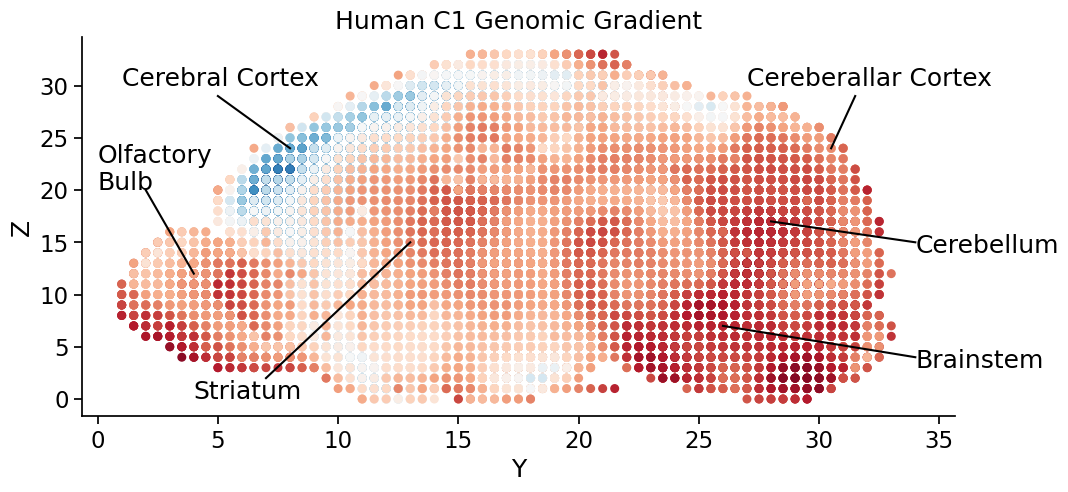

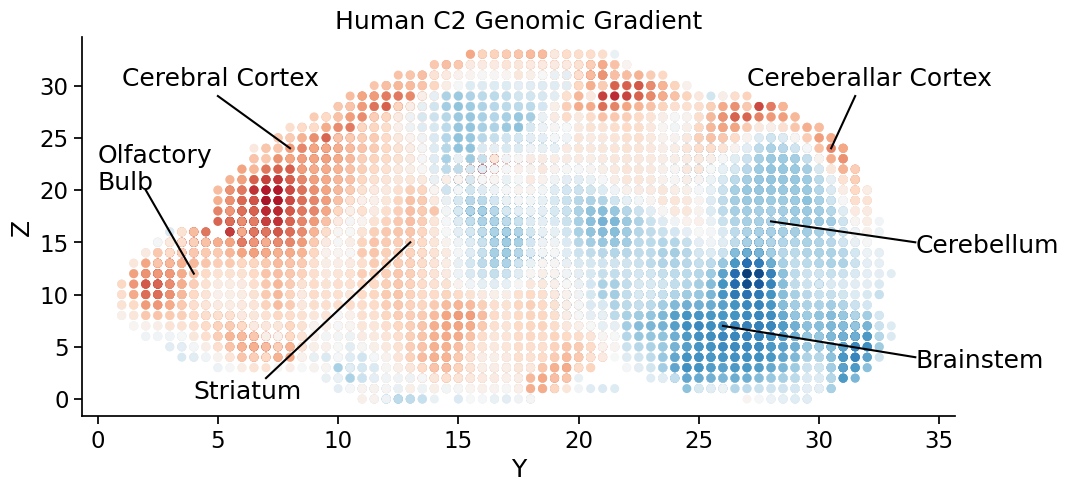

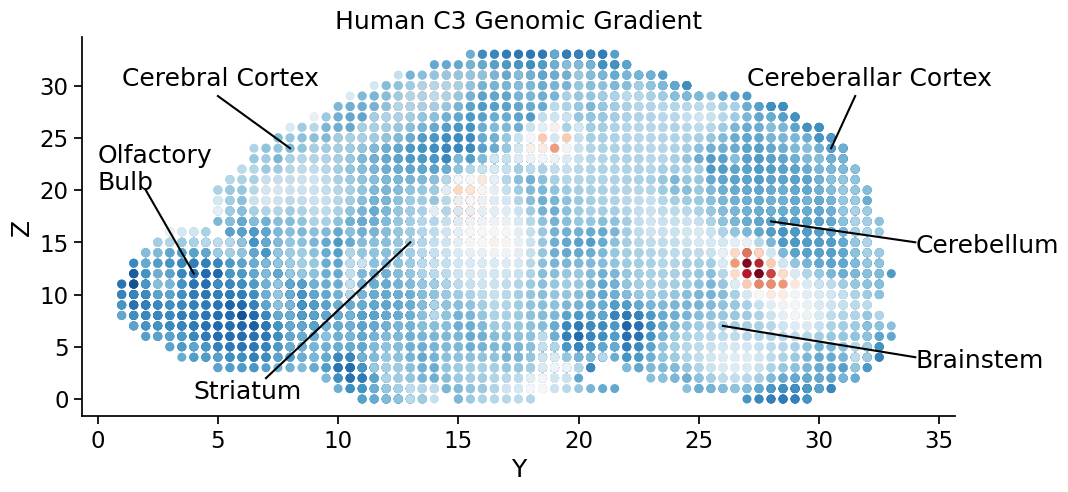

In [34]:
# project the PLS genetic components onto the brain and plot it

from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

sns.set_context('notebook',font_scale=1.5)

#pals = ['cividis','viridis','magma']

cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(1,4):
    sg = m_h_tfm[:,(i-1)]
    #else:
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='half_y', y='inv_z', aspect=2, 
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Human C%s Genomic Gradient'%(i))
    
    #annotate
    plt.text(1,30,'Cerebral Cortex')
    plt.plot([5,8],[29,24],c='k')
    
    plt.text(27,30,'Cereberallar Cortex')
    plt.plot([31.5,30.5],[29,24],c='k')
    
    plt.text(34,14,'Cerebellum')
    plt.plot([34,28],[15,17],c='k')
    
    plt.text(34,3,'Brainstem')
    plt.plot([34,26],[4,7],c='k')
    
    plt.text(0,20,'Olfactory\nBulb')
    plt.plot([2,4],[20,12],c='k')
    
    plt.text(4,0,'Striatum')
    plt.plot([7,13],[2,15],c='k')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('./figures/hum_project_mouse_C%s_RdBu_YZ.png'%i,
#                bbox_inches='tight')

    plt.show()


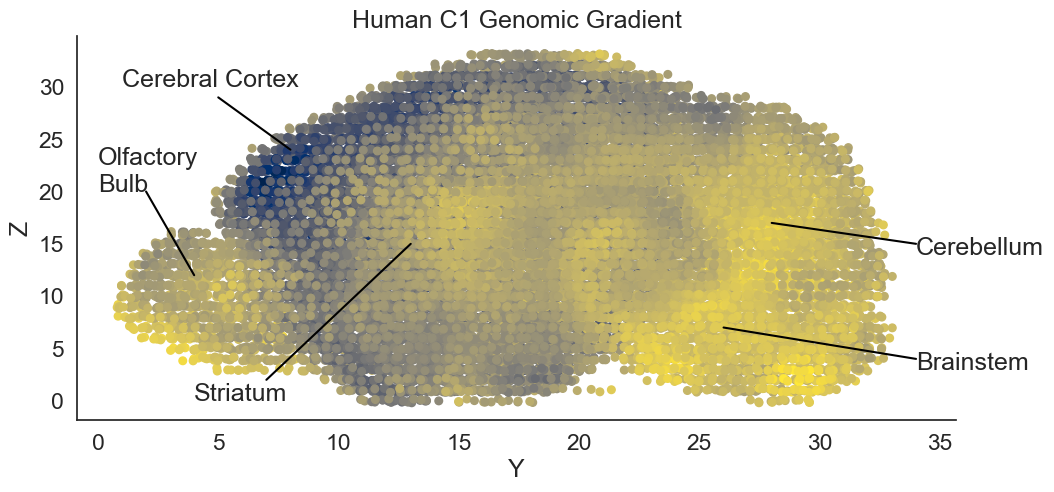

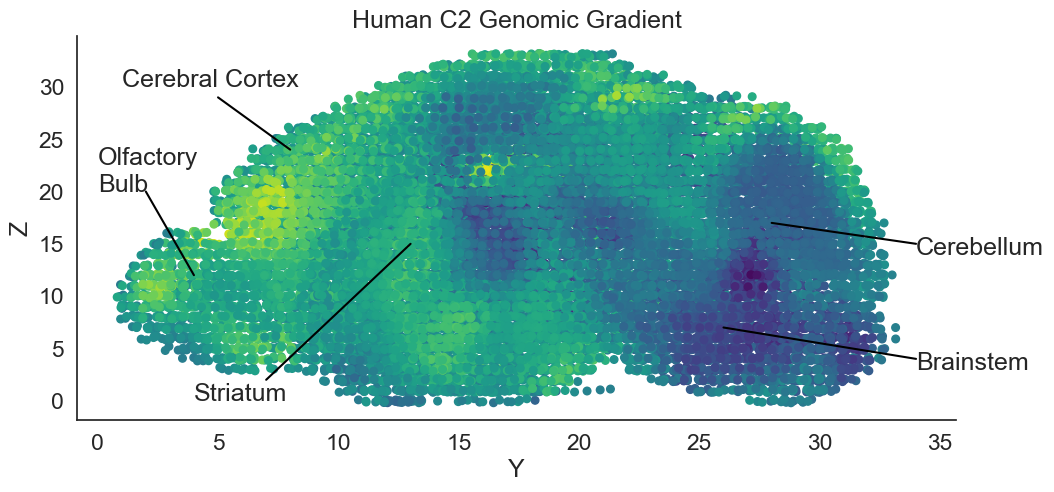

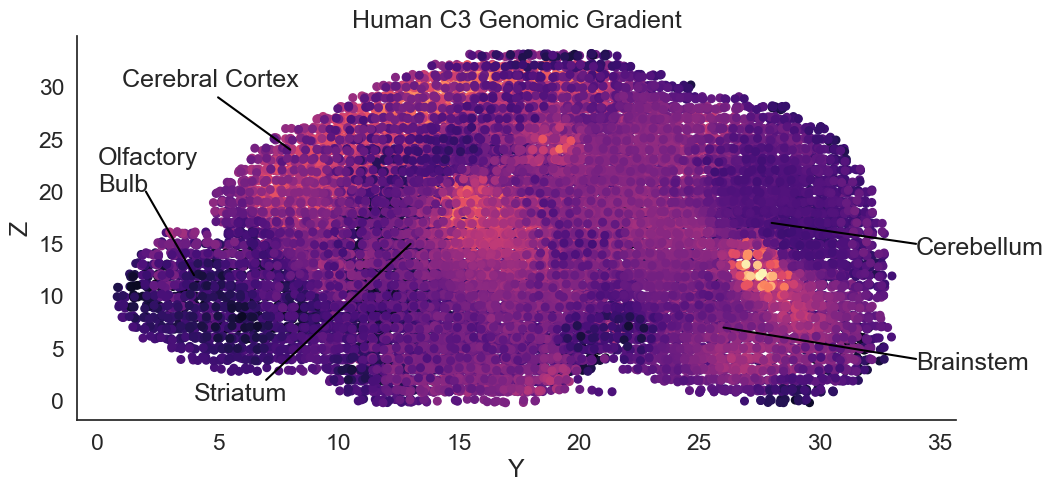

In [35]:
### Let's do it again, but change the colorscale to be feature-free, and
### jittering the data a bit to make it less grid-like

from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize


sns.set_context('notebook',font_scale=1.5)
sns.set_style('white',rc={'savefig.dpi':300})

pals = ['cividis','viridis','magma']

#cmap = sns.color_palette('RdBu_r',as_cmap=True)

for i in range(1,4):
    cmap = sns.color_palette(pals[(i-1)],as_cmap=True)
    sg = m_h_tfm[:,(i-1)]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='half_y', y='inv_z', aspect=2, 
                   x_jitter=0.2,y_jitter=0.2,
                   data=vdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Human C%s Genomic Gradient'%(i))
    
    #annotate
    plt.text(1,30,'Cerebral Cortex')
    plt.plot([5,8],[29,24],c='k')
    
#     plt.text(27,30,'Cereberallar Cortex')
#     plt.plot([31.5,30.5],[29,24],c='k')
    
    plt.text(34,14,'Cerebellum')
    plt.plot([34,28],[15,17],c='k')
    
    plt.text(34,3,'Brainstem')
    plt.plot([34,26],[4,7],c='k')
    
    plt.text(0,20,'Olfactory\nBulb')
    plt.plot([2,4],[20,12],c='k')
    
    plt.text(4,0,'Striatum')
    plt.plot([7,13],[2,15],c='k')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
    #sns.set(rc={'savefig.dpi':300})

#     plt.savefig('./figures/hum_project_mouse_C%s_Colors_YZ_jittered.png'%i,
#                bbox_inches='tight')

    plt.show()


# Predict mouse space with human transcriptomic information

In [36]:
preds = pls_mod.predict(pcamod.transform(hexp.T))


In [37]:
coords.loc[:,'inv_z'] = vdf.z.max() - vdf.z

In [38]:
# Need to flip signs for y and x (because of brain orientation)
coords.loc[:,'neg_y'] = coords.y.values * -1
coords.loc[:,'neg_x'] = coords.x.values * -1

neg_y
0.3748603594267744 0.0


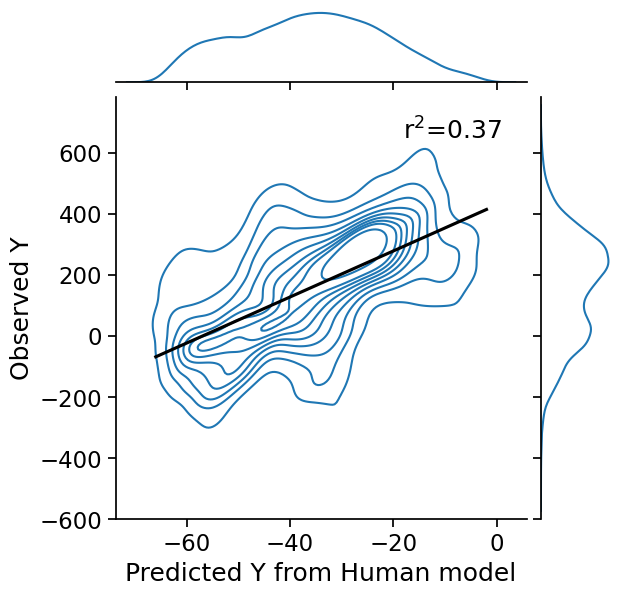

inv_z
0.14524348876556725 0.0


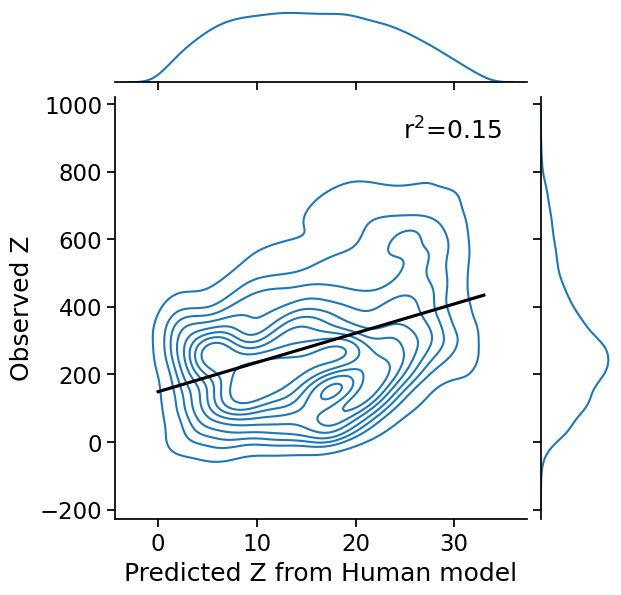

neg_x
0.08434644405866229 0.0


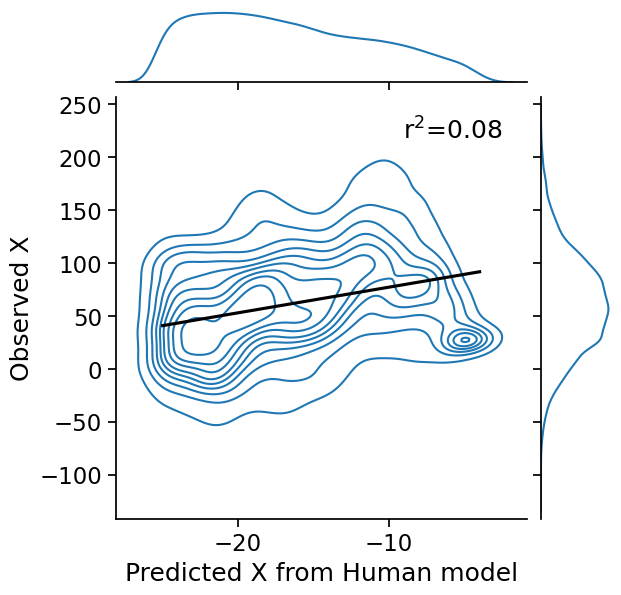

In [30]:
cols = ['neg_y','inv_z','neg_x']
axlabs = dict(zip(cols,['Y','Z','X']))
for i in range(3):
    print(cols[i])
    g = sns.jointplot(x=coords[cols[i]].values,y=preds[:,i],kind='kde',)
    sns.regplot(x=coords[cols[i]].values,y=preds[:,i], ax=g.ax_joint, marker='',line_kws={'color':'k'})
    g.ax_joint.set_xlabel('Predicted %s from Human model'%axlabs[cols[i]])
    g.ax_joint.set_ylabel('Observed %s'%axlabs[cols[i]])
    r,p = stats.pearsonr(x=coords[cols[i]].values,y=preds[:,i])
    print(r**2,p)
    plt.text(0.7,0.9,'r$^2$=%s'%round((r**2),2),transform=g.ax_joint.transAxes)
    #plt.savefig('./figures/HumPredMouse_%s.pdf'%cols[i])
    plt.show()

# ID contributing proteins

In [31]:
gcorr = np.corrcoef(np.concatenate([iexp,m_h_tfm.T]))

In [32]:
gcols = gdf.index.tolist() + ['C1','C2','C3']
gcorr = pandas.DataFrame(gcorr,index=gcols,columns=gcols)

In [33]:
for i in range(1,4):
    print('_____C%s_____'%i)
    thresh = int(round(len(gdf) * (0.05/2)))
    glist = gcorr.sort_values('C%s'%i)['C%s'%i].index.tolist()[:thresh]
    glist += gcorr.sort_values('C%s'%i)['C%s'%i].index.tolist()[-thresh:]
    hits = set(glist) & set(human[human['C%s_genelist'%i]==1].index.tolist())
    print(hits)
    print('\n')
    


_____C1_____
{'ZIC1', 'CALB2', 'FOXG1', 'SLC17A6', 'PAX6', 'GDA', 'GDF10'}


_____C2_____
{'FOXF2', 'RELN', 'C2', 'NEFH'}


_____C3_____
{'DRD2'}


